In [1]:
import os
import gym
from keras import backend as K
from keras import optimizers
from _base import build_env, experiment_dir
from _top_level import top_level
top_level()

Using TensorFlow backend.


In [2]:
from src.agents import DeepQAgent
from src.base import AnnealingVariable
from src.wrappers import wrap
from src.models.losses import huber_loss
from src.callbacks import BaseCallback
from src.callbacks import JupyterCallback
from src.utils import seed

In [ ]:
env_id = 'PongNoFrameskip-v4'
env_id

In [3]:
# set the random number seed
seed(1)

In [ ]:
output_dir = experiment_dir('../results', env_id, DeepQAgent.__name__)
output_dir

In [4]:
def make_environment():
    env = wrap(gym.make(env_id), 
        cache_rewards=True,
        noop_max=30,
        frame_skip=4,
        max_frame_skip=False,
        image_size=(84, 84),
        death_penalty=-1,
        clip_rewards=True,
        agent_history_length=4
    )
    env.unwrapped.seed(1)

    return env, output_dir

In [ ]:
env = make_environmentonment()

In [8]:
# create a file to save the weights to
weights_file = os.path.join(output_dir, 'weights.h5')

In [9]:
# create an agent
agent = DeepQAgent(env,
    render_mode='human',
    replay_memory_size=750000,
    prioritized_experience_replay=False,
    discount_factor=0.99,
    update_frequency=4,
    optimizer=optimizers.Adam(lr=2e-5),
    exploration_rate=AnnealingVariable(initial_value=1.0, final_value=0.01, steps=1e6),
    loss=huber_loss,
    target_update_freq=10000,
    dueling_network=False,
)
agent

DeepQAgent(
    env=<FrameStackEnv<ClipRewardEnv<PenalizeDeathEnv<DownsampleEnv<FrameSkipEnv<FireResetEnv<NoopResetEnv<RewardCacheEnv<TimeLimit<AtariEnv<PongNoFrameskip-v4>>>>>>>>>>>,
    render_mode='human'
    replay_memory_size=750000,
    prioritized_experience_replay=False,
    discount_factor=0.99,
    update_frequency=4,
    optimizer=<keras.optimizers.Adam object at 0x7f5712f3c748>,
    exploration_rate=AnnealingVariable(initial_value=1.0, final_value=0.01, steps=1000000),
    loss=huber_loss,
    target_update_freq=10000,
    dueling_network=False
)

In [10]:
# observe random movement in the environment to pre-fill the experience 
# replay queue with memories
agent.observe()

50336frame [01:07, 746.04frame/s]                        


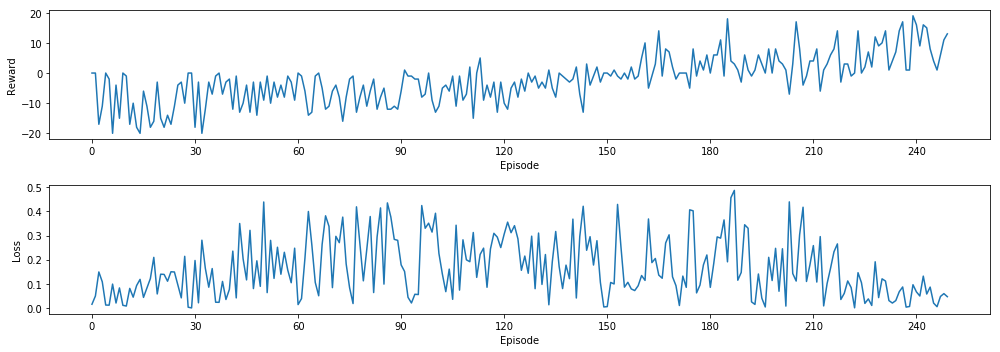

5000617frame [5:48:35, 232.09frame/s, loss=0.0869, score=21]                            


In [11]:
# create a callback for the training procedure to log metrics
callback = BaseCallback(weights_file)
plotter = JupyterCallback()
# train the agent with given parameters and the callback
agent.train(6e6, callback=[callback, plotter])
# save the weights to disk after the training procedure
agent.model.save_weights(weights_file, overwrite=True)

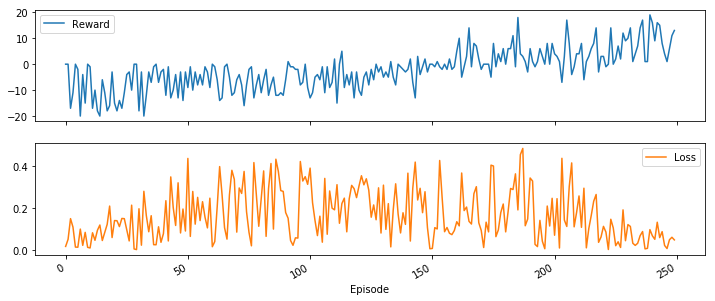

In [12]:
callback.export(os.path.join(output_dir, 'training'))

In [ ]:
env.close()
# clear the keras session to remove the training model from memory
K.clear_session()

In [15]:
env = make_environment()
# create a validation agent with a monitor attatched
agent = DeepQAgent(env)
# load the trained weights into the validation agent
agent.model.load_weights(weights_file)

In [16]:
# run the agent through validation episodes
df = agent.play()

100%|██████████| 100/100 [06:33<00:00,  3.51s/game, score=18]


In [17]:
df.head()

,Score
Episode,
0,20.0
1,20.0
2,16.0
3,4.0
4,20.0


In [18]:
df.tail()

,Score
Episode,
95,19.0
96,17.0
97,18.0
98,18.0
99,18.0


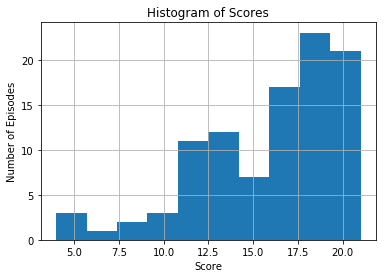

In [19]:
# plot the validation results and save the tables and figures to disk
agent.plot_episode_rewards(os.path.join(output_dir, 'play'))

In [ ]:
env.close()